# Homework Assignment #3: Computing with neurons
## Adrien Bourgain

# Question 1

In [1]:
import numpy as np

In [2]:
def tanh(x):
    return np.tanh(x)


def tanh_grad(x):
    return 1 - np.tanh(x)**2


class NN():
    def __init__(self,architecture, learning_rate=0.1, activation=lambda x: x, activation_grad=lambda x: 1):
        '''This is a fully connected NN. The architecture is a list, 
        with each element specifying the number of nodes in each layer'''
        self.arch = architecture
        self.num_layers = len(self.arch) - 1
        self.activation = activation
        self.activation_grad = activation_grad
        self.lr = learning_rate
        self.init_weights()
        
        
    def init_weights(self):
        np.random.seed(0) # don't modify this. GSI uses this for checking outputs
        self.weights = []
        self.biases = []
        for n in range(self.num_layers):
            self.weights.append(np.random.random(size=(self.arch[n], self.arch[n+1])))
            self.biases.append(np.random.random(size=(1, self.arch[n+1])))

        
    def feed_forward(self, X):
        self.a_ns = []
        self.z_ns = []
        self.a_ns.append(X)
        
        for n in range(self.num_layers):
            z_n = np.dot(self.a_ns[n], self.weights[n]) + self.biases[n]
            self.z_ns.append(z_n)
            self.a_ns.append(self.activation(z_n))
            
        return self.a_ns[-1]
            
    def loss_func(self, X, y):
        loss = 0
        batch_size, n_output = y.shape
        
        for m in range(batch_size):
            for i in range(n_output):
                loss += (X[m, i] - y[m, i])**2
                
        return (1 / (2 * batch_size * n_output)) * loss
    
    
    def calc_layer_errors(self, X, y):
        self.layer_errors = []
        batch_size, n_output = y.shape
        self.layer_errors.append((1 / (batch_size * n_output)) * (self.a_ns[-1] - y) * self.activation_grad(self.z_ns[-1]))

        for l in range(self.num_layers-1, 0, -1):
            self.layer_errors.append(np.dot(self.layer_errors[l - self.num_layers + 1], self.weights[l].T) * self.activation_grad(self.z_ns[l-1]))
        
        self.layer_errors.reverse()
        
        return self.layer_errors
    
    def calc_grads(self, X, y):
        self.calc_layer_errors(X, y)
        self.biases_grad, self.weights_grad = [], []
        
        for l in range(self.num_layers):
            self.weights_grad.append(np.dot(self.a_ns[l].T, self.layer_errors[l]))
            self.biases_grad.append(np.sum(self.layer_errors[l]))
        
    def back_prop(self, X, y):
        self.calc_grads(X, y)
        
        for l in range(self.num_layers):
            self.weights[l] -= self.lr * self.weights_grad[l]
            self.biases[l] -= self.lr * self.biases_grad[l]
    

## (a)

In [3]:
nn = NN(architecture=[6, 2, 2], learning_rate=0.1, activation=tanh, activation_grad=tanh_grad)
# print the initialized weights
nn.weights

[array([[0.5488135 , 0.71518937],
        [0.60276338, 0.54488318],
        [0.4236548 , 0.64589411],
        [0.43758721, 0.891773  ],
        [0.96366276, 0.38344152],
        [0.79172504, 0.52889492]]),
 array([[0.07103606, 0.0871293 ],
        [0.0202184 , 0.83261985]])]

## (b)

*For debugging*: if you use `np.random.random` to initialize weights and biases and set `np.random.seed(0)`. You will get `[[0.64027023 0.25119984]]` as the prediction

In [4]:
X = np.array([[-1, 1, -1, -1, 1, -1]])

In [5]:
# print the prediction
nn.feed_forward(X)

array([[0.64027023, 0.25119984]])

## (c)

*Hint*: For the definition of layer errors, you can refer to the matrial in bCourses: `Files > Homework > HW3 > Guide_ANN.pdf`. You will use these errors in back-propagation.

*For debugging*: `[array([[0.08505865, 0.23282824]]), array([[0.48392403, 0.58612371]])]` are errors for two layers.

In [6]:
y = np.array([[-1, -1]])

In [7]:
# print layer errors
nn.calc_layer_errors(X, y)

[array([[0.08505865, 0.23282824]]), array([[0.48392403, 0.58612371]])]

## (d)

We have the following formula for the weight update:
$$\frac{\partial C}{\partial w^l} = (a^{l-1})^T \delta^l$$
and 
$$\delta w^l = - \gamma \frac{\partial C}{\partial w^l}$$ with $\gamma$ the learning rate.

In [8]:
# print updated weights & biases
nn.back_prop(X, y)
print(f"nn.weights: \n{nn.weights}")
print(f"nn.biases: \n{nn.biases}")

nn.weights: 
[array([[0.55731937, 0.73847219],
       [0.59425751, 0.52160036],
       [0.43216066, 0.66917694],
       [0.44609308, 0.91505582],
       [0.9551569 , 0.3601587 ],
       [0.8002309 , 0.55217774]]), array([[0.07428843, 0.09106854],
       [0.05552456, 0.87538229]])]
nn.biases: 
[array([[0.53625587, 0.89380795]]), array([[0.67115198, 0.76300737]])]


# Question 2

**If you want, you can read the following material to help you with the code!**

Let's denote $a$ as the output of our simple perceptron model.

$$ \mathbf{a} = \sigma(\mathbf{z}) = \sigma(\mathbf{Xw+b}) $$

where $X\in \mathbb{R}^{N_{bz}\times N_f}$ is the input data, $N_{bz}$ is the batch size (i.e. number of samples in one calculation) and $N_f$ is the dimension of input features. $\mathbf{w}\in \mathbb{R}^{N_f\times N_o}$ is the weights matrix and $\mathbf{b}\in \mathbb{R}^{N_o}$ is the biases. $N_o$ is the dimension of outputs. $\sigma$ is the activation function.

The loss function is defined as half of the mean squared error (MSE) bewteen predicted values $\mathbf{a}$ and the ground truth $\mathbf{O}$:

$$ C = \frac{1}{2}\mathrm{MSE}(\mathbf{a, O}) = \frac{1}{2N_{bz}N_o}\sum_{m}^{N_{bz}}\sum_{i}^{N_o}(a_{mi}-O_{mi})^2$$

Using the chain rule to calculate the gradient of weights and biases. First define

$$ \boldsymbol{\delta} = \frac{\partial C}{\partial \mathbf{z}} = \frac{\partial C}{\partial \mathbf{a}}\odot \sigma'(z) = \frac{1}{N_{bz}N_o}(\mathbf{a}-\mathbf{O})\odot\sigma'(\mathbf{z})$$

where $\odot$ is elementwise product.

$$ \frac{\partial C}{\partial \mathbf{w}} =  \mathbf{X}^T\frac{\partial C}{\partial \mathbf{z}} = \mathbf{X}^T\boldsymbol{\delta}$$

$$ \frac{\partial C}{\partial \mathbf{b}} =  \sum_{m}^{N_{bz}}\boldsymbol{\delta}_m$$

where $\boldsymbol{\delta}_m$ is the $m$-th row of matrix $\boldsymbol{\delta}$.

In [9]:
class SimplePerceptron():
    """
    Implementation of simple perceptron regressor
    """
    def __init__(
        self, 
        input_dim, 
        output_dim, 
        learning_rate=0.0001,
        activation=lambda x: x,
        activation_grad=lambda x: 1
    ):
        """
        Initialize a simple perceptron regressor
        
        Parameters
        ----------
        input_dim: int
            Input dimension
        output_dim: int
            Output dimension
        learning_rate: float
            Learning Rate
        activation: Callable
            Activation function
        activation_grad: Callable
            Activation function's first derivative
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.activation_grad = activation_grad
        self.lr = learning_rate
        self.weights = np.random.random(size=(self.input_dim, self.output_dim))
        self.biases = np.random.random(size=(1, self.output_dim))

    def predict(self, X):
        """
        Get predicted values of given input
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        
        Returns
        -------
        y: numpy.ndarray
            Output, shape (n_samples, output_dim)
        """
        # Convert rank-1 array to rank-2
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        
        # Check that the dimension of accepted input data is the same as expected
        dim = X.shape[1]
        if dim != self.input_dim:
            raise Exception(f"Expected input size {self.input_dim}, accepted {dim}")
        
        self.z = np.dot(X, self.weights) + self.biases
        self.a = self.activation(self.z)
        return self.a
    
    def fit(self, X, y):
        """
        Fit the model by doing an steepest descent step
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        """        
        self.predict(X)
        
        errors = (self.a - y) * self.activation_grad(self.z) / y.size   # shape (n_samples, output_dim) 
        weights_grad = np.dot(X.T, errors)                              # shape (input_dim, ouput_dim)
        bias_grad = np.sum(errors, axis=0)                              # shape (output_dim,)

        # Update weights and biases from the gradient
        # just do a simple gradient descent
        self.weights -= self.lr * weights_grad
        self.biases -= self.lr * bias_grad
        
    def train_one_epoch(self, X, y, batch_size=32):
        """
        Train the model for one epoch
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        batch_size: int
            Batch size
        """
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        if len(y.shape) == 1:
            y = y.reshape((-1, 1))
            
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        for i in range(0, X.shape[0], batch_size):
            batch = indices[i: i+batch_size]
            self.fit(X[batch], y[batch])

    def evaluate(self, X, y):
        """
        Get the loss function with given data
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        
        Returns
        -------
        L: float
            Loss function value.
        """
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        if len(y.shape) == 1:
            y = y.reshape((-1, 1))
            
        y_pred = self.predict(X)
        # mean squared error
        return ((y_pred - y)**2).mean() / 2
    
    def get_weights(self):
        """
        Get weights and biases
        """
        return self.weights.copy(), self.biases.copy()
    
    def set_weights(self, weights, biases):
        """
        Set weights and biases
        """
        self.weights = weights
        self.biases = biases

## (a)

*Hint: Think about what activation function in the SimplePerceptron model should be used to perform a logistic regression?*

One-dimension logistic regression expression:

$$ y = \frac{1}{1+e^{-(ax+b)}} $$

**ANSWER:** We define the sigmoid function:
$$ \sigma (x) = \frac{1}{1+e^{-x}} $$
whose derivative is:
$$ \sigma ' (x) = \sigma (x) (1 - \sigma (x)) $$

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

We can import the Titanic dataset and clean it.

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [12]:
# Load the dataset
df = pd.read_csv("../Datasets/titanic.csv")
df.head()

# We drop empty rows 
subdf = df[["Pclass", "Sex", "SibSp", "Parch", "Embarked", "Age", "Fare", "Survived"]].dropna()

# Categorical features: ["Pclass", "Sex", "Embarked"]
categorical_features = subdf[["Pclass", "Sex", "Embarked"]]
# Continuous features: ["Age", "Fare", "SibSp", "Parch"]
continuous_features = subdf[["Age", "Fare", "SibSp", "Parch"]]

In [13]:
# Continuous features
X_cont = continuous_features.values # n_sample * n_feature

# Scale (or normalize)
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_cont)

In [14]:
# Categorical features
X_cate = categorical_features.values

# OneHotEncoding
encoder = OneHotEncoder()

X_onehot = encoder.fit_transform(X_cate).toarray()

In [15]:
# Recombine categorical & continuous features
X = np.hstack((X_norm, X_onehot))

# Reshape the outputs to (n_samples, 1) in order to avoid unexpected broadcasting
y = subdf['Survived'].values.reshape(-1, 1) 

# print the dimensions
print(f"X.shape: {X.shape}, y.shape: {y.shape}")

X.shape: (712, 12), y.shape: (712, 1)


## (b)

Here, we will do the following things:

+ Split the data to $k$-folds, use the $k-1$ folds for training and the other fold for testing
+ In each fold, further split the training data ($k-1$ folds of the whole dataset) by 80\%/20\%. Use the 80\% to train the model in certain epochs and use the 20\% as a validation set to determine the best model during training.
+ For each fold, plot the validation loss against training
+ For each fold, report the mean squared error of the total training set (the $k-1$ fold data) and the test set (the other fold data)  

In [16]:
from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt


def KFoldCrossValidation(
    k, X, y, epochs, draw_curve=True, learning_rate=0.0001, 
    activation=lambda x: x, activation_grad=lambda x: 1,
    verbose=True
):
    """
    K-Fold Validation
    
    Parameters
    ---------
    k: int
        The number of fold in validation
    X: numpy.ndarray
        Input samples, shape (n_samples, input_dim)
    y: numpy.ndarray
        Labels, shape (n_samples, output_dim)
    epochs: int
        Number of training epochs
    draw_curve: bool
        Whether to draw the validation loss against training steps
    learning_rate: float
        Learning rate
    activation: Callable
        Activation function
    activation_grad: Callable
        Gradient of activate function
    verbose: bool
        Whether to print information
    
    Returns
    ------
    model: list
        List of k models
    """
    # Reshape the X,y if they are rank-1
    if len(X.shape) == 1:
        X = X.reshape((-1, 1))
    if len(y.shape) == 1:
        y = y.reshape((-1, 1))
    input_dim = X.shape[1]
    output_dim = y.shape[1]
    
    # do a 5-fold validation
    kf = KFold(n_splits=k, shuffle=True)
    
    if draw_curve:
        n_row, n_col = int(np.ceil(k / 3)), 3
        fig, axes = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row), constrained_layout=True)
        axes = axes.flatten()
    
    models = []
    train_err_list, test_err_list = [], []
    for i, (train_selector, val_selector) in enumerate(kf.split(X)):
        # Decide training examples and testing examples for this fold
        X_train, X_test = X[train_selector], X[val_selector]
        y_train, y_test = y[train_selector], y[val_selector]
        
        # define your models here
        model = SimplePerceptron(
            input_dim, 
            output_dim, 
            learning_rate,
            activation,
            activation_grad
        )
        
        # futher split the X_train by 80%/20%
        # use train_test_split function in sklearn
        X_train_in, X_val, y_train_in, y_val = train_test_split(X_train, y_train, test_size=0.2)
        
        lowest_val_err = np.inf
        val_err_list = []
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            model.train_one_epoch(X_train_in, y_train_in)
            val_err = model.evaluate(X_val, y_val)
            val_err_list.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights, biases = model.get_weights()

        # The final number of epochs is when the minimum error in validation set occurs    
        if verbose:
            print("Number of epochs with lowest validation:", np.argmin(val_err_list))
        model.set_weights(weights, biases)
        models.append(model)

        # Report MSE on X_train and X_test
        train_err = model.evaluate(X_train, y_train)
        train_err_list.append(train_err)
        test_err = model.evaluate(X_test, y_test)
        test_err_list.append(test_err)
        
        if draw_curve:
            axes[i].plot(np.arange(epochs), np.log10(val_err_list), label='Validation loss')
            axes[i].set_xlabel('Epochs')
            axes[i].set_ylabel('Log Loss')
            axes[i].legend()
            axes[i].set_title(f"Epoch {i+1}")
    
    if verbose:      
        print("Final results:")
        print(f"Training error: {np.mean(train_err_list)} +/- {np.std(train_err_list)}")
        print(f"Testing error: {np.mean(test_err_list)} +/- {np.std(test_err_list)}")
    
    return models

We can do a test with all the features in X.

Number of epochs with lowest validation: 998
Number of epochs with lowest validation: 999
Number of epochs with lowest validation: 999
Number of epochs with lowest validation: 999
Number of epochs with lowest validation: 991
Final results:
Training error: 0.0728297232472212 +/- 0.0009222690202456673
Testing error: 0.07542130275539519 +/- 0.006291614273472316


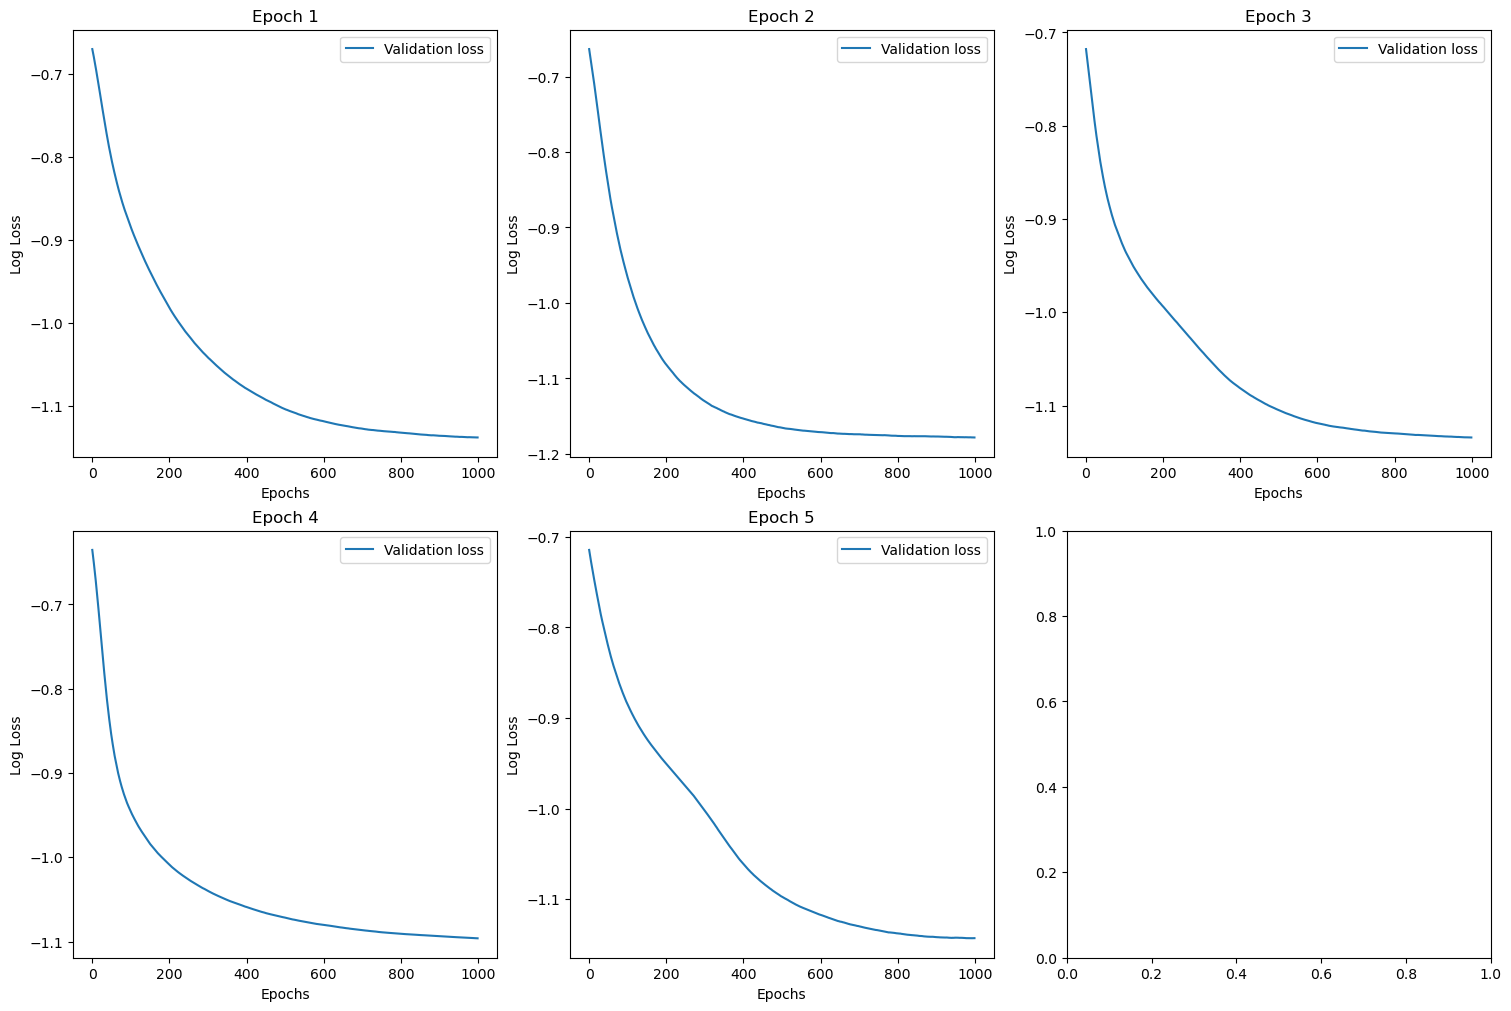

In [17]:
models = KFoldCrossValidation(k=5, X=X, y=y, epochs=1000, draw_curve=True, learning_rate=0.01, activation=sigmoid, activation_grad=sigmoid_grad, verbose=True)

We can print the prediction for the model 0:

In [18]:
# print(f"prediction: {models[0].predict(X)}")

We can also create a function to evaluate the trained models by averaging their results, taking a basic threshold (pred = 1 if y_pred > 0.5, else 0) for the prediction, and using sklearn metrics.

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_models(X, y, models:list, verbose:bool=False):
    # Prepare to collect predictions
    predictions = []
    
    # Iterate through models to get predictions
    for model in models:
        pred = model.predict(X)  # Ensure this method returns the probability or score of class 1
        predictions.append(pred)
    
    # Convert predictions to a numpy array 
    predictions = np.array(predictions)
    
    # Average predictions
    average_predictions = np.mean(predictions, axis=0)
    average_predictions_binary = np.round(average_predictions)
    
    # Compute metrics
    accuracy = accuracy_score(y, average_predictions_binary)
    precision = precision_score(y, average_predictions_binary)
    recall = recall_score(y, average_predictions_binary)
    f1 = f1_score(y, average_predictions_binary)

    if verbose:
        # Print metrics
        print(f"Accuracy: {round(accuracy*100, 2)}%")
        print(f"Precision: {round(precision*100, 2)}%")
        print(f"Recall: {round(recall*100, 2)}%")
        print(f"F1-Score: {round(f1*100, 2)}%")

    return accuracy, precision, recall, f1

In [20]:
e = evaluate_models(X, y, models, verbose=True)

Accuracy: 80.34%
Precision: 79.37%
Recall: 69.44%
F1-Score: 74.07%


**ANSWER:** We can predict who will survive. The performance of the prediction is not exceptional but it seems better than random prediction.

We can try to iteratively determine which features are the best to predict the survival of the passengers.

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
def features_selection(X, y, feature_names, performance_metric="f1"):
    selected_features = []
    remaining_features = list(feature_names)
    best_performance = 0  # Initialize with 0 or an appropriate value for comparison

    print("First evaluation of each feature:")

    while remaining_features:
        best_current_feature = None
        for feature in remaining_features:
            # Try adding this feature to the selected ones
            temp_selected = selected_features + [feature]
            temp_indices = [feature_names.index(feat) for feat in temp_selected]
            X_temp = X[:, temp_indices]

            # Use KFoldCrossValidation to train models
            models = KFoldCrossValidation(k=5, X=X_temp, y=y, epochs=1000, draw_curve=False, learning_rate=0.01, activation=sigmoid, activation_grad=sigmoid_grad, verbose=False)
            
            # Evaluate the models using the evaluate_models function
            accuracy, precision, recall, f1 = evaluate_models(X=X_temp, y=y, models=models, verbose=False)
            
            if performance_metric == "f1":
                current_performance = f1  
            elif performance_metric == "accuracy":
                current_performance = accuracy  
            elif performance_metric == "precision":
                current_performance = precision 
            elif performance_metric == "recall":
                current_performance = f1
            else:
                print("!!!Warning, performance metric not defined!!!")
                return

            if len(selected_features) == 0:
                print(f"\t-Feature {feature}: accuracy: {round(accuracy*100,2)}%, precision: {round(precision*100,2)}%, recall: {round(recall*100,2)}%, F1-score: {round(f1*100,2)}%.")
            
            if current_performance > best_performance:
                best_performance = current_performance
                best_current_feature = feature

        if best_current_feature:
            selected_features.append(best_current_feature)
            remaining_features.remove(best_current_feature)
            print(f"Added {best_current_feature}. New best performance ({performance_metric}): {round(best_performance*100,2)}%")
        else:
            # Stop if no improvement
            break

    return selected_features

We can find the first best features, using f1-score as the performance metric:

In [23]:
# Prepare feature_names considering the encoding
# Adjust the feature_names list according to your encoded feature names
feature_names = ["Age", "Fare", "SibSp", "Parch"] + list(encoder.get_feature_names_out())

# Run forward selection
selected_features = features_selection(X, y, feature_names)

print("Selected features:", selected_features)

First evaluation of each feature:
	-Feature Age: accuracy: 59.55%, precision: 0.0%, recall: 0.0%, F1-score: 0.0%.
	-Feature Fare: accuracy: 67.42%, precision: 70.29%, recall: 33.68%, F1-score: 45.54%.
	-Feature SibSp: accuracy: 59.55%, precision: 0.0%, recall: 0.0%, F1-score: 0.0%.
	-Feature Parch: accuracy: 59.97%, precision: 51.81%, recall: 14.93%, F1-score: 23.18%.
	-Feature x0_1: accuracy: 67.42%, precision: 65.22%, recall: 41.67%, F1-score: 50.85%.
	-Feature x0_2: accuracy: 59.55%, precision: 0.0%, recall: 0.0%, F1-score: 0.0%.
	-Feature x0_3: accuracy: 66.43%, precision: 56.86%, recall: 70.49%, F1-score: 62.95%.
	-Feature x1_female: accuracy: 77.95%, precision: 75.29%, recall: 67.71%, F1-score: 71.3%.
	-Feature x1_male: accuracy: 77.95%, precision: 75.29%, recall: 67.71%, F1-score: 71.3%.
	-Feature x2_C: accuracy: 63.48%, precision: 60.77%, recall: 27.43%, F1-score: 37.8%.
	-Feature x2_Q: accuracy: 59.55%, precision: 0.0%, recall: 0.0%, F1-score: 0.0%.
	-Feature x2_S: accuracy: 5

We can find the first best features, using accuracy as the performance metric:

In [24]:
# Run forward selection
selected_features = features_selection(X, y, feature_names, performance_metric="accuracy")

print("Selected features:", selected_features)

First evaluation of each feature:
	-Feature Age: accuracy: 59.55%, precision: 0.0%, recall: 0.0%, F1-score: 0.0%.
	-Feature Fare: accuracy: 67.56%, precision: 70.5%, recall: 34.03%, F1-score: 45.9%.
	-Feature SibSp: accuracy: 59.55%, precision: 0.0%, recall: 0.0%, F1-score: 0.0%.
	-Feature Parch: accuracy: 61.66%, precision: 53.89%, recall: 36.11%, F1-score: 43.24%.
	-Feature x0_1: accuracy: 67.42%, precision: 65.22%, recall: 41.67%, F1-score: 50.85%.
	-Feature x0_2: accuracy: 58.57%, precision: 47.98%, recall: 28.82%, F1-score: 36.01%.
	-Feature x0_3: accuracy: 66.43%, precision: 56.86%, recall: 70.49%, F1-score: 62.95%.
	-Feature x1_female: accuracy: 77.95%, precision: 75.29%, recall: 67.71%, F1-score: 71.3%.
	-Feature x1_male: accuracy: 77.95%, precision: 75.29%, recall: 67.71%, F1-score: 71.3%.
	-Feature x2_C: accuracy: 63.48%, precision: 60.77%, recall: 27.43%, F1-score: 37.8%.
	-Feature x2_Q: accuracy: 59.55%, precision: 0.0%, recall: 0.0%, F1-score: 0.0%.
	-Feature x2_S: accurac

**ANSWER:** We played with the features to determine which would be the best to predict survival. It seems that first F1-score is a better metric to do so.
Then the best features to predict survival are:
* the sex of the passenger,
* the fare he or she paid,
* the port of embarkation, and
* the passenger class.
We can deduce that being a woman, with an expensive ticket, and living in the highest classes of the boat gives you a better chance to get back to shore.

# Question 3

## (a)

**Note**: `KFoldCrossValidation` returns a model list, just pick any one of them (for example, the first) for prediction on test dataset.

In [25]:
def generate_X(number, boundary):
    x = (np.random.random(number) * 2 - 1) * boundary
    return x
    
def generate_data(number, stochasticity=0.2):
    x = generate_X(number, 10)
    ratio = generate_X(number, stochasticity) + 1
    y = 3 * np.sin(x) * ratio + 5
    return x, y

In [26]:
def show_correlation(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    r = [
        np.min([np.min(y_pred), np.min(y_true)]), 
        np.max([np.max(y_pred), np.max(y_true)])
    ]
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    plt.scatter(y_pred, y_true, s=5)
    ax.plot(r, r, color='red')
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Ground truth")
    corr = np.corrcoef([y_pred, y_true])[1, 0]
    print("Correlation coefficient:", corr)

def show_plot(x, y_true, y_pred=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.scatter(x, y_true, s=0.5, label='Ground Truth')
    if y_pred is not None:
        ax.scatter(x, y_pred, s=0.5, label="Predicted")
    ax.legend()

First, generate the training data and plot it.

In [27]:
x_train, y_train = generate_data(number=5000)

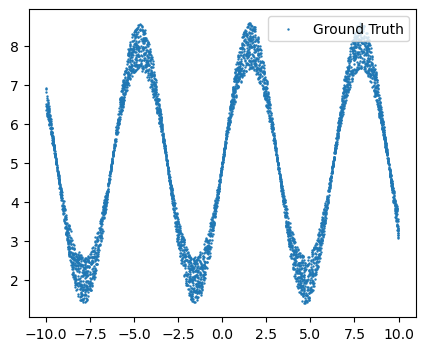

In [28]:
show_plot(x_train, y_train)

Number of epochs with lowest validation: 999
Number of epochs with lowest validation: 999
Number of epochs with lowest validation: 999
Number of epochs with lowest validation: 999
Number of epochs with lowest validation: 999
Final results:
Training error: 2.27770457981783 +/- 0.009790671456611994
Testing error: 2.278835170315401 +/- 0.05550716244330872


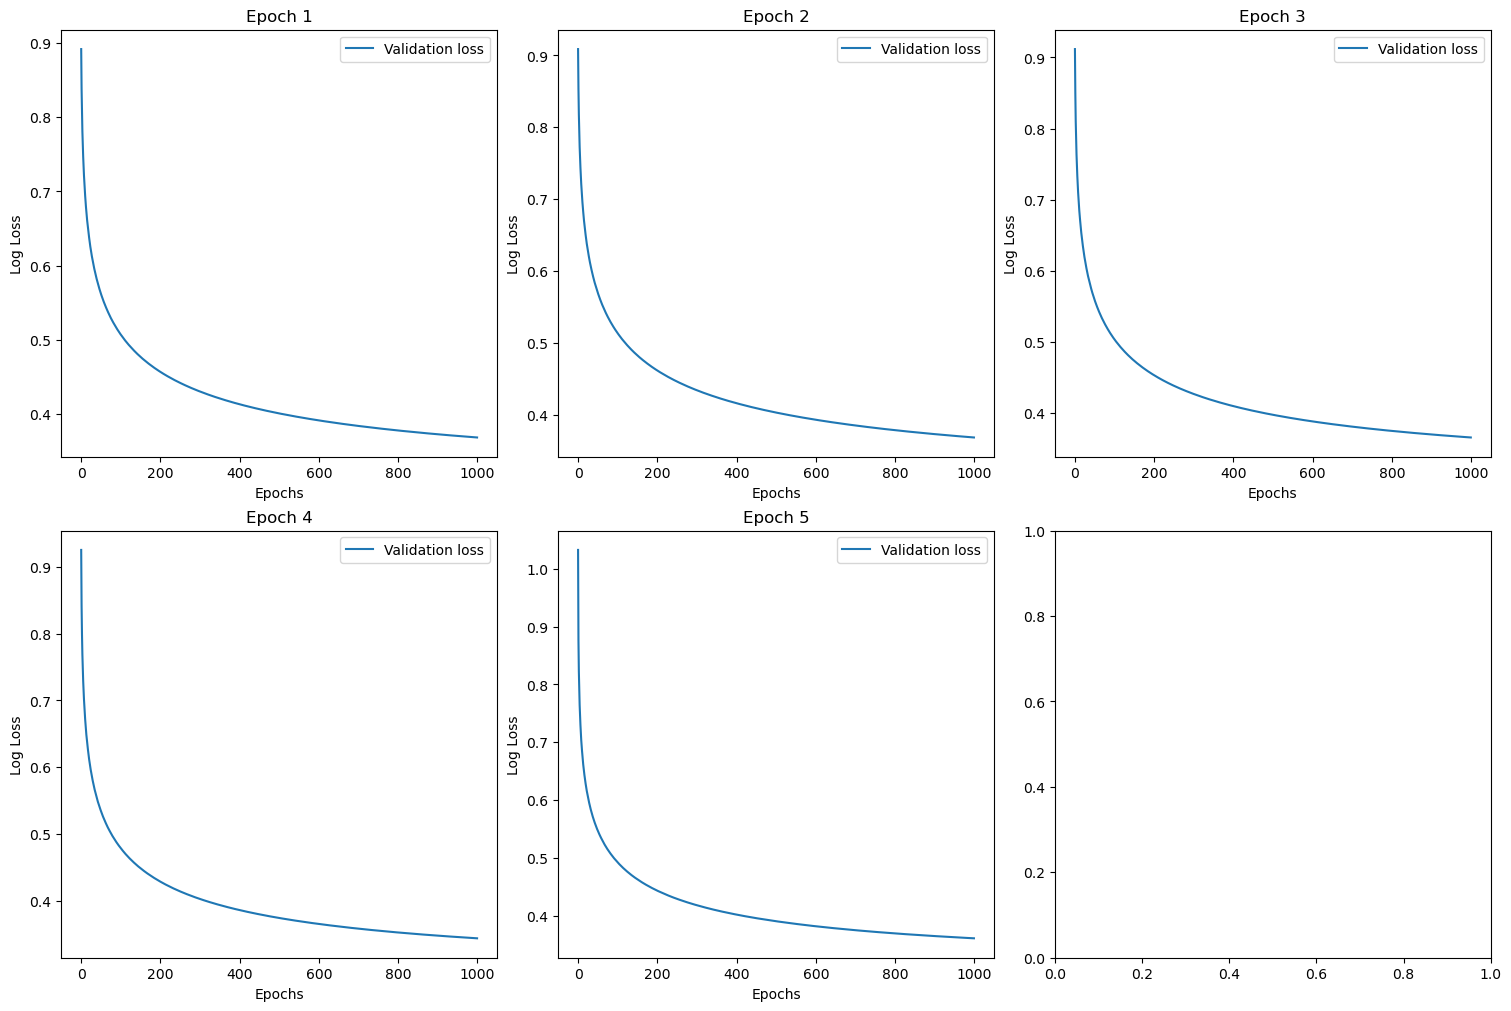

In [29]:
models = KFoldCrossValidation(k=5, X=x_train, y=y_train, epochs=1000, draw_curve=True, learning_rate=0.01, activation_grad=tanh_grad, verbose=True)

In [30]:
y_train_pred = models[1].predict(x_train)

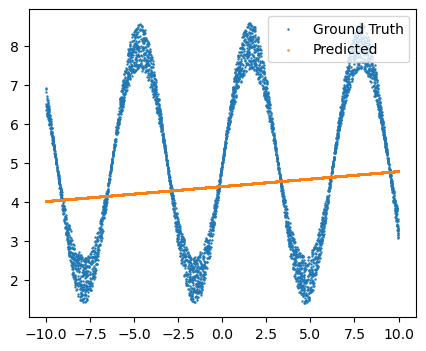

In [31]:
show_plot(x_train, y_train, y_train_pred)

**ANSWER:** The prediction does not seem very accurate.

Generate the test data:

In [32]:
x_test, y_test = generate_data(number=1000)

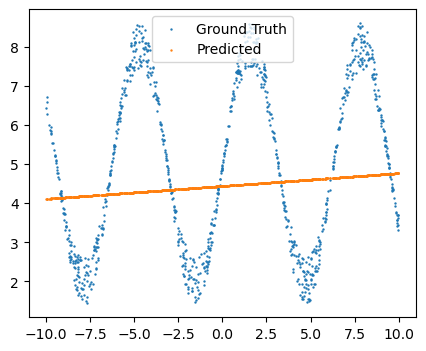

In [33]:
y_test_pred = models[-1].predict(x_test)
show_plot(x_test, y_test, y_test_pred)

Correlation coefficient: 0.20729837313919627


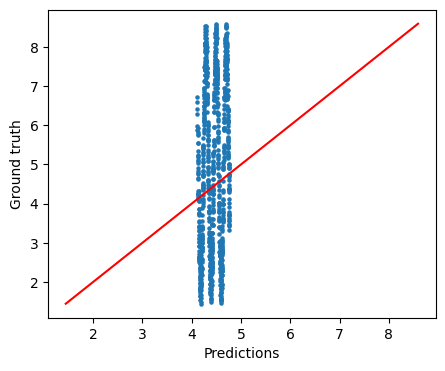

In [34]:
show_correlation(y_test_pred, y_test)

**ANSWER:** The prediction is very poor, it is certainly a limitation due to the number of layers (only one perceptron is not sufficient to approximate a such complex function).

## (b)

In [35]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


def KFoldCrossValidationMLP(
    k, X, y, epochs, 
    learning_rate=0.01, 
    activation='tanh',
    hidden_layers=(8,),
    verbose=True
):
    """
    K-Fold Validation for MLPRegressor
    
    Parameters
    ---------
    k: int
        The number of fold in validation
    X: numpy.ndarray
        Input samples, shape (n_samples, input_dim)
    y: numpy.ndarray
        Labels, shape (n_samples, output_dim)
    epochs: int
        Number of training epochs
    kwargs: keyword arguments
        Arguments to init a SimplePerceptron model. i.e. learning_rate, activation, activation_grad
    
    Returns
    ------
    model: SimplePerceptron
        The best model
    """
    # MLPRegressor takes 2D array for features
    # and 1D array for labels if the dimension of output is 1
    X = X.reshape(-1, 1) if len(X.shape) == 1 else X

    # do a 5-fold validation
    kf = KFold(n_splits=k, shuffle=True)
    
    models = []
    train_err_list, test_err_list = [], []
    for i, (train_selector, val_selector) in enumerate(kf.split(np.arange(X.shape[0]))):
        # Decide training examples and testing examples for this fold
        X_train, X_test = X[train_selector], X[val_selector]
        y_train, y_test = y[train_selector], y[val_selector]
        
        model = MLPRegressor(
            max_iter=epochs,
            activation=activation, 
            learning_rate_init=learning_rate,
            hidden_layer_sizes=hidden_layers,
            early_stopping=True, validation_fraction=0.2, learning_rate='constant', 
        )
        model.fit(X_train, y_train)
        models.append(model)

        # Report MSE on X_train and X_test
        y_train_pred = model.predict(X_train)
        train_err = mean_squared_error(y_train_pred, y_train)
        train_err_list.append(train_err)
        
        y_test_pred = model.predict(X_test)
        test_err = mean_squared_error(y_test_pred, y_test)
        test_err_list.append(test_err)
        if verbose:
            print(f"Train error: {train_err}, Test error: {test_err}")
        
    
    if verbose:      
        print("Final results:")
        print(f"Training error: {np.mean(train_err_list)}+/-{np.std(train_err_list)}")
        print(f"Testing error: {np.mean(test_err_list)}+/-{np.std(test_err_list)}")
    
    return models[np.argmin(test_err_list)]

In [36]:
model = KFoldCrossValidationMLP(k=5, X=x_train, y=y_train, epochs=1000, learning_rate=0.01, activation='tanh', hidden_layers=(1,), verbose=True)

Train error: 4.2385892387870685, Test error: 3.927942033122161
Train error: 4.015652627582886, Test error: 4.2030759725275155
Train error: 4.152652259632136, Test error: 4.263933157066591
Train error: 4.162986695705755, Test error: 4.261686954640115
Train error: 4.178742020145302, Test error: 4.155530130523651
Final results:
Training error: 4.14972456837063+/-0.07334668753241101
Testing error: 4.162433649576006+/-0.12396704704421936


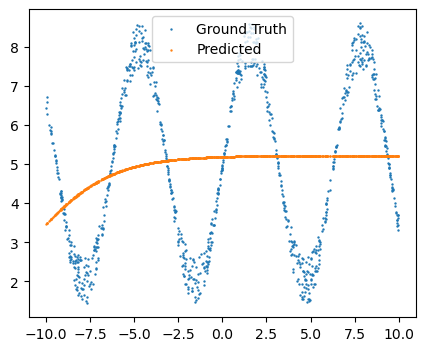

In [37]:
y_test_pred = model.predict(x_test.reshape(-1, 1))
show_plot(x_test, y_test, y_test_pred)

Correlation coefficient: 0.23492304968114272


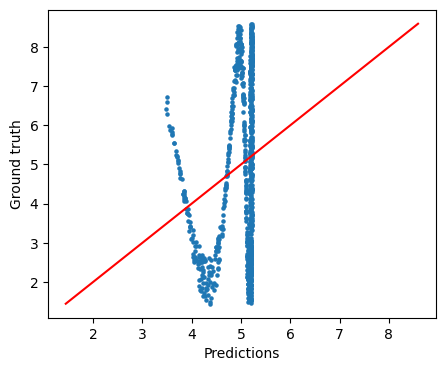

In [38]:
show_correlation(y_test_pred, y_test)

**ANSWER:** The result is better than our simple perceptron. It begins to approximate the curve at the origin. However, it is still not convincing, certainly due to the unique hidden layer. 

## (c)

In [39]:
model = KFoldCrossValidationMLP(k=5, X=x_train, y=y_train, epochs=1000, learning_rate=0.01, activation='tanh', hidden_layers=(10,), verbose=False)

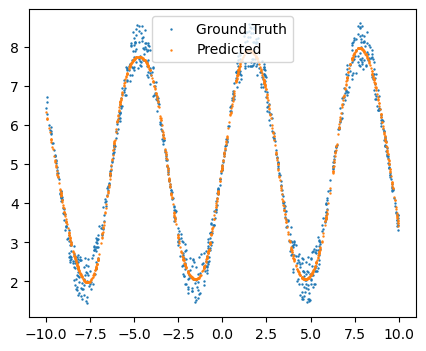

In [40]:
y_test_pred = model.predict(x_test.reshape(-1, 1))
show_plot(x_test, y_test, y_test_pred)

Correlation coefficient: 0.9915004074800428


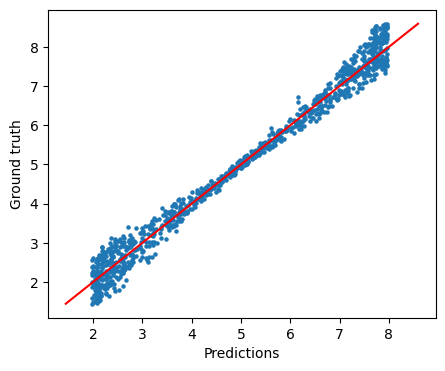

In [41]:
show_correlation(y_test_pred, y_test)

**ANSWER:** The approximation of the sinus curve is now more accurate, using 10 hidden layers instead of only one, and training on a sufficient number of epochs.